# Motivating examples
This document shows how SparseSC can be used in places where simple difference-in-differences can't.

## Basic setup

In [1]:
#If running from the repo and you would like to use the local pkg version uncomment the following lines, otherwise comment
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
#Load code
import numpy as np
import random
import matplotlib.pyplot as plt
import SparseSC as SC

exec(open("./example_graphs.py").read()) #if we don't want an __init.py__

def simple_summ(fit, Y):
    print("V_pen=%s, W_pen=%s" % (fit.V_penalty, fit.weight_penalty))
    print("V=%s" % np.diag(fit.V))
    print("Treated weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[0,49], fit.sc_weights[0,99], sum(fit.sc_weights[0,:])))
    print("Sim Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[1,49], fit.sc_weights[1,99], sum(fit.sc_weights[1,:])))
    print("Uns Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[51,49], fit.sc_weights[51,99], sum(fit.sc_weights[51,:])))
    Y_sc = fit.predict(Y[fit.control_units, :])
    print("Treated diff: %s" % (Y - Y_sc)[0,:])


In [3]:
#make sure the results are the same each time we run
random.seed(12345) 
np.random.seed(12345)

Setup common data parameters

In [4]:
N1,N0_sim,N0_not = 2,50,50
N0 = N0_sim + N0_not
N=N1+N0
treated_units = range(N1)
control_units = list(set(range(N)) - set(treated_units))
T0,T1 = 5, 5
T=T0+T1
proto_te = np.hstack((np.zeros((1,T0)), np.full((1,T0), 2)))

## Differential Trends

In [5]:
proto_sim = np.array(range(0,T,1),ndmin=2)
proto_not = np.array(range(0,2*T,2),ndmin=2)
proto_tr  = proto_sim + proto_te
Y1 = np.matmul(np.ones((N1,1)), proto_tr)
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not)+ \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

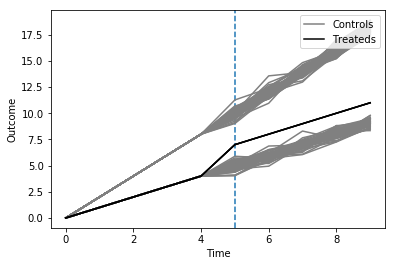

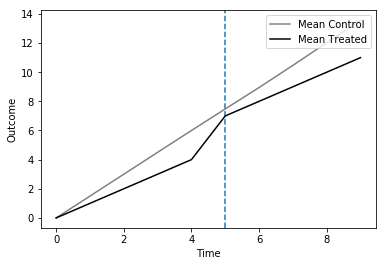

In [6]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
raw_all.show()
raw_means.show()

Analyze

In [7]:
#Currently the built-in joint opimization of penalties isn't great, so do two steps
ret_full = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, max_pl=200) #just getting V_pen
V_penalty = ret_full.fit.V_penalty
#simple_summ(ret_full.fit, Y)
ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[V_penalty], weight_penalty=0.00001, ret_CI=True)
simple_summ(ret.fit, Y)

V_pen=15284132.4692, W_pen=1e-05
V=[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.22357167e-05
   7.98197395e-05]
Treated weights: sim=0.00800005766691, uns=0.00600011533387, sum=0.700008650037
Sim Con weights: sim=0.00800005766691, uns=0.00600011533387, sum=0.700008650037
Uns Con weights: sim=0.0, uns=0.00604449697477, sum=0.697789772095
Treated diff: [  0.00000000e+00  -1.44167285e-05  -2.88334571e-05  -4.32501856e-05
  -5.76669142e-05   2.01882801e+00   2.04048115e+00   2.02031057e+00
   1.98233678e+00   1.95454751e+00]


Visualize

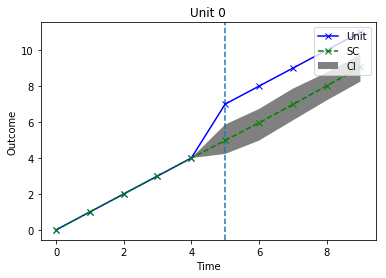

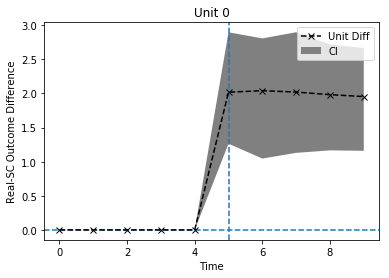

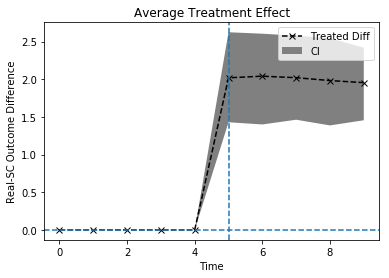

In [8]:
Y_sc = ret.fit.predict(Y[control_units, :])
[sc_raw, sc_diff] = ind_sc_plots(Y[0,:], Y_sc[0,:], T0, ind_ci=ret.ind_CI)
plt.figure("sc_raw")
plt.title("Unit 0")
sc_raw.show()
plt.figure("sc_diff")
plt.title("Unit 0")
sc_diff.show()
[te] = te_plot(ret)
plt.figure("te")
plt.title("Average Treatment Effect")
te.show()

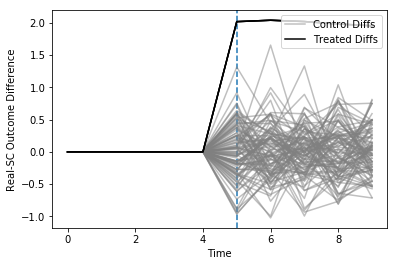

In [9]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
diffs_plt.show()

## Different cycles 

In [10]:
proto_sim = np.array([0,1,4,3,4,5,6,9,8,9],ndmin=2)
proto_not = np.array([0,3,2,4,3,5,4,6,5,7],ndmin=2)
proto_tr  = proto_sim + proto_te
Y1 = np.matmul(np.ones((N1,1)), proto_tr)
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

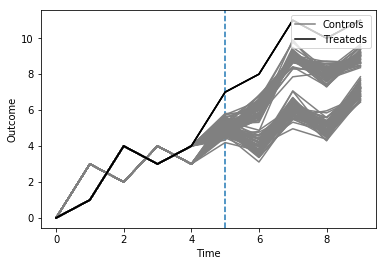

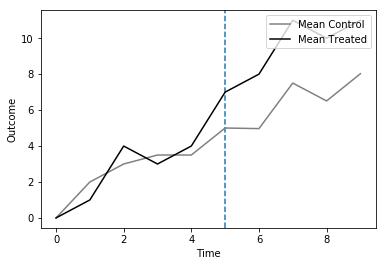

In [11]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
raw_all.show()
raw_means.show()

Analyze

In [12]:
#Currently the built-in joint opimization of penalties isn't great, so do two steps
ret_full = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, max_pl=200) #just getting V_pen
V_penalty = ret_full.fit.V_penalty
#simple_summ(ret_full.fit, Y)
ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[V_penalty], weight_penalty=0.00001, ret_CI=True)
simple_summ(ret.fit, Y)

V_pen=1918776.95759, W_pen=1e-05
V=[  0.00000000e+00   0.00000000e+00   6.87814993e-05   0.00000000e+00
   1.07081244e-05]
Treated weights: sim=0.0198265590492, uns=0.000322096424276, sum=1.00743277368
Sim Con weights: sim=0.0198265590492, uns=0.000322096424276, sum=1.00743277368
Uns Con weights: sim=0.0, uns=0.000327619799612, sum=1.00755919414
Treated diff: [ 0.         -0.03964242  0.00247855 -0.03840314 -0.01362627  1.93415031
  1.9837574   2.02594578  1.98625963  1.98911671]


Visualize

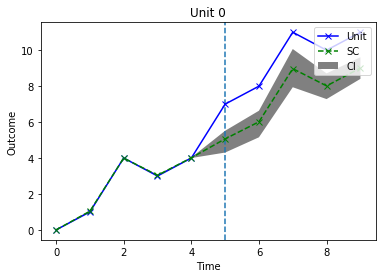

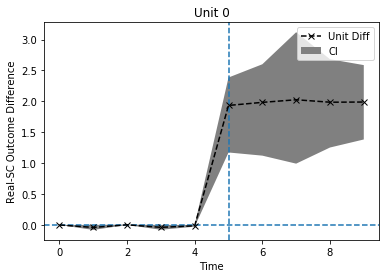

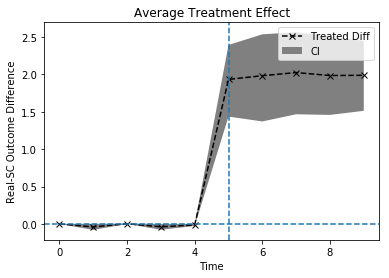

In [13]:
Y_sc = ret.fit.predict(Y[control_units, :])
[sc_raw, sc_diff] = ind_sc_plots(Y[0,:], Y_sc[0,:], T0, ind_ci=ret.ind_CI)
plt.figure("sc_raw")
plt.title("Unit 0")
sc_raw.show()
plt.figure("sc_diff")
plt.title("Unit 0")
sc_diff.show()
[te] = te_plot(ret)
plt.figure("te")
plt.title("Average Treatment Effect")
te.show()

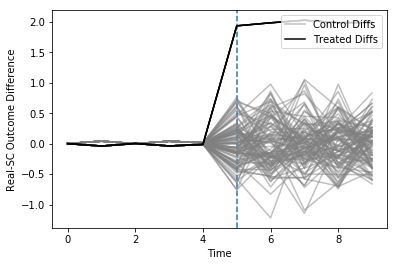

In [14]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
diffs_plt.show()